In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import easydatascience as eds
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data = pd.read_csv('appstore_games.csv').drop(['URL', 'Icon URL', 'Description'], axis=1)
data = data.loc[~data['Average User Rating'].isnull()]

data[['Subtitle', 'In-app Purchases']] = data[['Subtitle', 
                                               'In-app Purchases']].fillna('NA')
data['Languages'] = data['Languages'].fillna('EN')
data.columns = data.columns.str.replace(' ', '_')
data.Age_Rating = data.Age_Rating.str.replace('+', '').astype('int32')

data['Size_MB'] = round(data['Size']/1024**2, 3)
data = data.drop('Size', axis=1)

#eds.look(data).sort_values(by='nulls', ascending=False)

In [114]:
#Instance frequency within these attributes was examined
data['Has_Subtitle'] = np.where(data['Subtitle']=='NA', 0, 1)
data['Free_to_Play'] = np.where(data['Price']==0, 1, 0)
data['In-app_Purchases'] = np.where(data['In-app_Purchases']=='NA', 0, 1)
data['Multilingual'] = np.where(data['Languages']=='EN', 0, 1)
data = data.drop(['Subtitle', 'Primary_Genre', 'Price', 'Languages'], axis=1)

data['Original_Release_Date'] = data['Original_Release_Date'].str.replace('/', '-')
data['Current_Version_Release_Date'] = data['Current_Version_Release_Date'].str.replace('/', '-')

data['Release_Year'] = pd.to_datetime(data['Original_Release_Date']).dt.year
data['Release_Month'] = pd.to_datetime(data['Original_Release_Date']).dt.month
data['Days_Since_Last_Update'] = (pd.Timestamp.now().date() - pd.to_datetime(
            data['Current_Version_Release_Date']).dt.date).astype('timedelta64[D]')

data = data.drop(['Original_Release_Date', 'Current_Version_Release_Date'], axis=1)

#names = pd.read_csv('usafirstnames.csv')['Names'].str.lower().values.tolist()
#names = '|'.join(names)
#data['Developer'] = data['Developer'].str.lower()
#data['Indie'] = np.where(data['Developer'].str.contains(names), 1, 0)
data = data.drop('Developer', axis=1)

data = eds.one_hot_encode(data, 'Genres')
data = eds.degrade_columns(data, ', ', filter=True)

In [115]:
from sklearn.preprocessing import KBinsDiscretizer

kbdisc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

num_data = data
num_data[['User_Rating_Count', 'Size_MB']] = kbdisc.fit_transform(num_data[['User_Rating_Count', 
                                                                            'Size_MB']])

corr_drop_list = eds.get_abv_corr(num_data, num_data['Average_User_Rating'], threshold=0.03)
num_data = num_data.drop(corr_drop_list, axis=1)

#eds.look(train, pred='Average_User_Rating').sort_values(by='corrAverage_User_Rating',
#                                                        ascending=False)

In [116]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(num_data, test_size=0.3, random_state=13)

test_IDN = test[['ID', 'Name']]
test = test.drop(['ID', 'Name'], axis=1)
X_test, y_test = test.drop('Average_User_Rating', axis=1), test['Average_User_Rating']

#Outliers
train_IDN = train[['ID', 'Name']]
train = train.drop(['ID', 'Name'], axis=1)
X_train, y_train = train.drop('Average_User_Rating', axis=1), train['Average_User_Rating']

R2 score:  0.25159002649250417
RMSE:  0.6520850038676677
Cross-Validation: 
	Scores: [0.69491947 0.66223936 0.70677167 0.6573875 ]
	Mean: 0.6803294984574422
	Standard deviation: 0.021009781238676327


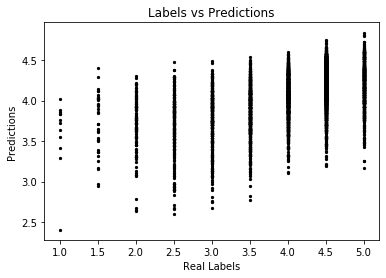

In [118]:
#eds.print_abv_ft_corr(X_train, 0.45)
import xgboost
from sklearn.linear_model import LinearRegression

xgb_reg = eds.simple_reg_model(xgboost.XGBRegressor(objective ='reg:squarederror'),
                               X_train, y_train, return_model=True)

In [16]:
#EDS
for feature in list(num_data):
    if data[feature].nunique() < 3:
        print((data.groupby(feature)[feature].count()/len(data)).sort_values(ascending=False))

In-app_Purchases
1    0.612882
0    0.387118
Name: In-app_Purchases, dtype: float64
Has_Subtitle
0    0.63973
1    0.36027
Name: Has_Subtitle, dtype: float64
Free_to_Play
1    0.83653
0    0.16347
Name: Free_to_Play, dtype: float64
Multilingual
0    0.665388
1    0.334612
Name: Multilingual, dtype: float64
Board
0    0.886655
1    0.113345
Name: Board, dtype: float64
Casual
0    0.9303
1    0.0697
Name: Casual, dtype: float64
Puzzle
0    0.819072
1    0.180928
Name: Puzzle, dtype: float64
Entertainment
0    0.50734
1    0.49266
Name: Entertainment, dtype: float64
Simulation
0    0.835207
1    0.164793
Name: Simulation, dtype: float64


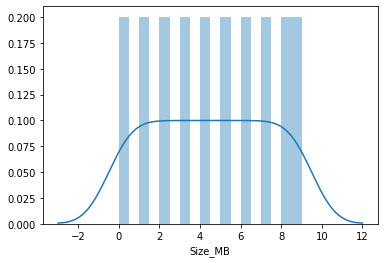

In [57]:
#EDS
sns.distplot(data['Size_MB'], kde_kws={'bw':1})
sns.boxplot(train['Days_Since_Last_Update'])
sns.distplot(data['Days_Since_Last_Update'])

In [ ]:
#COMUNICATING INSIGHTS

In [66]:
print((num_data.groupby('Average_User_Rating')['Average_User_Rating'].count()/len(num_data)).sort_values(ascending=False))

Average_User_Rating
4.5    0.378389
4.0    0.227748
5.0    0.130935
3.5    0.122338
3.0    0.067980
2.5    0.041926
2.0    0.020897
1.5    0.007935
1.0    0.001852
Name: Average_User_Rating, dtype: float64


In [95]:
eds.look(num_data, 'Average_User_Rating').sort_values(by='corrAverage_User_Rating', ascending=False)

___________________________
Data types:
 int64      7
int32      4
float64    4
object     1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ratio,uniques,skewness,corrAverage_User_Rating
Average_User_Rating,float64,7561,9,0,0.0,"[[4.0, 3.5, 3.0, 2.5, 2.0, 4.5, 1.5, 5.0, 1.0]]",-1.157873,1.000000
Release_Year,int64,7561,12,0,0.0,"[[2008, 2009, 2016, 2010, 2011, 2014, 2017, 20...",-0.359626,0.231705
ID,int64,7561,7488,0,0.0,"[[284921427, 284926400, 284946595, 285755462, ...",-0.229083,0.210280
User_Rating_Count,float64,7561,10,0,0.0,"[[9.0, 7.0, 4.0, 5.0, 6.0, 8.0, 1.0, 3.0, 0.0,...",-0.007187,0.190414
Has_Subtitle,int32,7561,2,0,0.0,"[[0, 1]]",0.582229,0.185376
Size_MB,float64,7561,10,0,0.0,"[[1.0, 0.0, 2.0, 3.0, 4.0, 6.0, 5.0, 9.0, 8.0,...",-0.000113,0.154844
In-app_Purchases,int32,7561,2,0,0.0,"[[0, 1]]",-0.463586,0.151692
Casual,int64,7561,2,0,0.0,"[[0, 1]]",3.380341,0.052122
Puzzle,int64,7561,2,0,0.0,"[[1, 0]]",1.658021,0.046951
Multilingual,int32,7561,2,0,0.0,"[[1, 0]]",0.701152,0.037830


In [96]:
X_train.shape

(5292, 13)

In [99]:
range(1.0, 5.5, 0.5)

TypeError: 'float' object cannot be interpreted as an integer

In [123]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5292 entries, 12054 to 357
Data columns (total 13 columns):
User_Rating_Count         5292 non-null float64
In-app_Purchases          5292 non-null int32
Size_MB                   5292 non-null float64
Has_Subtitle              5292 non-null int32
Free_to_Play              5292 non-null int32
Multilingual              5292 non-null int32
Release_Year              5292 non-null int64
Days_Since_Last_Update    5292 non-null float64
Board                     5292 non-null int64
Casual                    5292 non-null int64
Puzzle                    5292 non-null int64
Entertainment             5292 non-null int64
Simulation                5292 non-null int64
dtypes: float64(3), int32(4), int64(6)
memory usage: 496.1 KB
